### adaptive threshold - fail

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from pathlib import Path
from datetime import datetime
import random
import pandas as pd
import numpy as np
import re
import glob
import cv2
import PIL.Image as Image
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

from dev.devlib import *
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore') 
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Hyperparameter Setting

In [3]:
CFG = {
    'MODEL_NAME':'ConvNext',
    'DATA_PATH':Path(r'F:\datasets\dacon\hansol'),
    'IMG_SIZE':224,
    'EPOCHS':10,
    'LEARNING_RATE':3e-3,
    'BATCH_SIZE':16,
    'SEED':41
}
train_path =CFG['DATA_PATH'] / 'train'
test_path = CFG['DATA_PATH'] / 'test'

## Fixed RandomSeed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [5]:
def rename_folder():
    """
    한글 폴더 명 0~n_classes 변경
    """
    folder_dict ={id:label for id,label in enumerate(os.listdir(train_path))}
    os.chdir(train_path)
    for old_folder_name in os.listdir(train_path):
        if old_folder_name in folder_dict.values():
            new_folder_name = str(list(folder_dict.keys())[list(folder_dict.values()).index(old_folder_name)])
            # print(old_folder_name,new_folder_name)
            os.rename(old_folder_name, new_folder_name)
folder_dict = {0: '가구수정',
               1: '걸레받이수정',
               2: '곰팡이',
               3: '꼬임',
               4: '녹오염',
               5: '들뜸',
               6: '면불량',
               7: '몰딩수정',
               8: '반점',
               9: '석고수정',
               10: '오염',
               11: '오타공',
               12: '울음',
               13: '이음부불량',
               14: '창틀,문틀수정',
               15: '터짐',
               16: '틈새과다',
               17: '피스',
               18: '훼손'}

## Data Pre-processing

In [6]:
# './train/*/*'
all_img_list = glob.glob(str(CFG['DATA_PATH'] / 'train/*/*'))
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x : str(x).split('\\')[-2])
### binary 18 / 0~17
df['label'] = df['label'].apply(lambda x : '0' if int(x)!=18 else '1')

train_df, val, _, _ = train_test_split(df, df['label'], test_size=0.1, stratify=df['label'], random_state=CFG['SEED'])

## CustomDataset

In [7]:
class TDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = [int(l) for l in label_list] if label_list is not None else None
        self.transforms = transforms
        self.feature = []

        for img_path in tqdm(self.img_path_list):
            image = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
            if self.transforms is not None:
                image = self.transforms(image=image)['image']
            else:
                image = cv2.resize(image,(224,224),interpolation=cv2.INTER_NEAREST)/255.
            self.feature.append(image)

    def __getitem__(self, index):
        if self.label_list is not None:
            return self.feature[index], self.label_list[index]
        else:
            return self.feature[index]
        
    def __len__(self):
        return len(self.img_path_list)

In [8]:
train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.5), std=(0.5), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.5), std=(0.5), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [9]:
from dev.devlib import TDataset, transform_adaptive_th

train_dataset = TDataset(train_df['img_path'].values, train_df['label'].values, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = TDataset(val['img_path'].values, val['label'].values, test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

100%|██████████| 346/346 [00:03<00:00, 90.81it/s]


### model define

In [10]:
class ConvNeXt(nn.Module):
    def __init__(self, num_classes=19):
        super(ConvNeXt, self).__init__()
        self.model = models.convnext_base(weights=models.convnext.ConvNeXt_Base_Weights.IMAGENET1K_V1)
        # self.model = models.efficientnet_b0(weights=models.efficientnet.EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.model.classifier[2] = nn.Linear(in_features=self.model.classifier[2].in_features, out_features=num_classes)
        # input dim == 0
        self.model.features[0][0] = nn.Conv2d(1, 128, kernel_size=(4, 4), stride=(4, 4))
        
        # for param in self.model.parameters():
        #     param.requires_grad = False

        # for param in self.model.classifier.parameters():
        #     param.requires_grad = True

        self.model.features[0][0].requires_grad_(True)

    def forward(self,x):
        x = self.model(x)
        return x
        
class Ringed_Res_Net(nn.Module):
    def __init__(self,in_ch=1,n_classes=19,bb_grad_=False):
        super().__init__()
        backbone = Ringed_Res_Unet(in_ch,10)
        backbone.load_state_dict(torch.load('./INTERRUPTED.pth',map_location='cpu'))
        self.encoder = nn.Sequential(OrderedDict([(n,m) for n,m in backbone.named_children()][:5]))
        self.encoder.requires_grad_(True)
        self.down = RRU_down(256,256)
        self.classifier = nn.Sequential(
                            nn.Linear(256*7*7,256,bias=False),
                            nn.ReLU(inplace=True),
                            nn.Dropout(p=0.4),
                            nn.Linear(256, n_classes,bias=False)
                            )

    def forward(self,x):
        x = self.encoder(x)
        x = self.down(x)
        x = x.view(-1,256*7*7)
        x = self.classifier(x)
        return x

In [27]:
iter(train_loader).__next__()[1]

tensor([1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0])

## Train

In [11]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    
    best_score = 0
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(train_loader):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(imgs)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')
       
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_score < _val_score:
            best_score = _val_score
            best_model = model
    
    return best_model

In [12]:
def validation(model, criterion, val_loader, device,return_lists=False):
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            pred = model(imgs)
            
            loss = criterion(pred, labels)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()
            
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='weighted')
    if return_lists:
        return true_labels, preds
    else:
        return _val_loss, _val_score

## Run!!

In [13]:
BaseModel = ConvNeXt
model = BaseModel(2)
model.train()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

100%|██████████| 22/22 [00:10<00:00,  2.14it/s]


Epoch [1], Train Loss : [0.71610] Val Loss : [0.68093] Val Weighted F1 Score : [0.44087]


100%|██████████| 22/22 [00:11<00:00,  1.87it/s]


Epoch [2], Train Loss : [0.68294] Val Loss : [0.67658] Val Weighted F1 Score : [0.44087]


100%|██████████| 22/22 [00:11<00:00,  1.88it/s]


Epoch [3], Train Loss : [0.67951] Val Loss : [0.67703] Val Weighted F1 Score : [0.44087]


100%|██████████| 22/22 [00:11<00:00,  1.87it/s]


Epoch [4], Train Loss : [0.68030] Val Loss : [0.67892] Val Weighted F1 Score : [0.44087]
Epoch 00004: reducing learning rate of group 0 to 1.5000e-03.


100%|██████████| 22/22 [00:11<00:00,  1.89it/s]


Epoch [5], Train Loss : [0.67713] Val Loss : [0.67665] Val Weighted F1 Score : [0.44087]


100%|██████████| 22/22 [00:11<00:00,  1.89it/s]


Epoch [6], Train Loss : [0.67623] Val Loss : [0.67678] Val Weighted F1 Score : [0.44087]


100%|██████████| 22/22 [00:11<00:00,  1.90it/s]


Epoch [7], Train Loss : [0.67585] Val Loss : [0.68232] Val Weighted F1 Score : [0.44087]
Epoch 00007: reducing learning rate of group 0 to 7.5000e-04.


100%|██████████| 22/22 [00:11<00:00,  1.89it/s]


Epoch [8], Train Loss : [0.67632] Val Loss : [0.67670] Val Weighted F1 Score : [0.44087]


100%|██████████| 22/22 [00:11<00:00,  1.89it/s]


Epoch [9], Train Loss : [0.67598] Val Loss : [0.67659] Val Weighted F1 Score : [0.44087]


100%|██████████| 22/22 [00:11<00:00,  1.89it/s]

Epoch [10], Train Loss : [0.67602] Val Loss : [0.67663] Val Weighted F1 Score : [0.44087]
Epoch 00010: reducing learning rate of group 0 to 3.7500e-04.


In [14]:
infer_model = train(infer_model, optimizer, train_loader, val_loader, scheduler, device)

100%|██████████| 22/22 [00:11<00:00,  1.84it/s]


Epoch [1], Train Loss : [0.67613] Val Loss : [0.67657] Val Weighted F1 Score : [0.44087]


100%|██████████| 22/22 [00:11<00:00,  1.85it/s]


Epoch [2], Train Loss : [0.67566] Val Loss : [0.67653] Val Weighted F1 Score : [0.44087]


100%|██████████| 22/22 [00:11<00:00,  1.85it/s]


Epoch [3], Train Loss : [0.67602] Val Loss : [0.67664] Val Weighted F1 Score : [0.44087]
Epoch 00013: reducing learning rate of group 0 to 1.8750e-04.


100%|██████████| 22/22 [00:11<00:00,  1.86it/s]


Epoch [4], Train Loss : [0.67607] Val Loss : [0.67656] Val Weighted F1 Score : [0.44087]


100%|██████████| 22/22 [00:11<00:00,  1.85it/s]


Epoch [5], Train Loss : [0.67582] Val Loss : [0.67654] Val Weighted F1 Score : [0.44087]


100%|██████████| 22/22 [00:11<00:00,  1.85it/s]


Epoch [6], Train Loss : [0.67512] Val Loss : [0.67654] Val Weighted F1 Score : [0.44087]
Epoch 00016: reducing learning rate of group 0 to 9.3750e-05.


100%|██████████| 22/22 [00:11<00:00,  1.86it/s]


Epoch [7], Train Loss : [0.67524] Val Loss : [0.67654] Val Weighted F1 Score : [0.44087]


100%|██████████| 22/22 [00:11<00:00,  1.86it/s]


Epoch [8], Train Loss : [0.67553] Val Loss : [0.67653] Val Weighted F1 Score : [0.44087]


100%|██████████| 22/22 [00:11<00:00,  1.86it/s]


Epoch [9], Train Loss : [0.67552] Val Loss : [0.67653] Val Weighted F1 Score : [0.44087]
Epoch 00019: reducing learning rate of group 0 to 4.6875e-05.


100%|██████████| 22/22 [00:11<00:00,  1.87it/s]

Epoch [10], Train Loss : [0.67567] Val Loss : [0.67653] Val Weighted F1 Score : [0.44087]


In [15]:
infer_model = train(infer_model, optimizer, train_loader, val_loader, scheduler, device)

100%|██████████| 22/22 [00:11<00:00,  1.98it/s]


Epoch [1], Train Loss : [0.67545] Val Loss : [0.67653] Val Weighted F1 Score : [0.44087]


100%|██████████| 22/22 [00:11<00:00,  1.98it/s]


Epoch [2], Train Loss : [0.67615] Val Loss : [0.67653] Val Weighted F1 Score : [0.44087]
Epoch 00022: reducing learning rate of group 0 to 2.3438e-05.


100%|██████████| 22/22 [00:11<00:00,  1.97it/s]


Epoch [3], Train Loss : [0.67544] Val Loss : [0.67653] Val Weighted F1 Score : [0.44087]


100%|██████████| 22/22 [00:11<00:00,  1.97it/s]


Epoch [4], Train Loss : [0.67523] Val Loss : [0.67653] Val Weighted F1 Score : [0.44087]


100%|██████████| 22/22 [00:11<00:00,  1.98it/s]


Epoch [5], Train Loss : [0.67555] Val Loss : [0.67653] Val Weighted F1 Score : [0.44087]
Epoch 00025: reducing learning rate of group 0 to 1.1719e-05.


100%|██████████| 22/22 [00:11<00:00,  1.97it/s]


Epoch [6], Train Loss : [0.67550] Val Loss : [0.67653] Val Weighted F1 Score : [0.44087]


100%|██████████| 22/22 [00:11<00:00,  1.97it/s]


Epoch [7], Train Loss : [0.67551] Val Loss : [0.67653] Val Weighted F1 Score : [0.44087]


100%|██████████| 22/22 [00:11<00:00,  1.96it/s]


Epoch [8], Train Loss : [0.67569] Val Loss : [0.67653] Val Weighted F1 Score : [0.44087]
Epoch 00028: reducing learning rate of group 0 to 5.8594e-06.


100%|██████████| 22/22 [00:11<00:00,  1.97it/s]


Epoch [9], Train Loss : [0.67569] Val Loss : [0.67653] Val Weighted F1 Score : [0.44087]


 13%|█▎        | 26/195 [01:12<07:50,  2.78s/it]


KeyboardInterrupt: 

In [51]:
infer_model = train(infer_model, optimizer, train_loader, val_loader, scheduler, device)

100%|██████████| 22/22 [01:20<00:00,  3.65s/it]


Epoch [1], Train Loss : [0.89778] Val Loss : [1.61185] Val Weighted F1 Score : [0.50795]
Epoch 00031: reducing learning rate of group 0 to 1.8750e-04.


100%|██████████| 22/22 [01:22<00:00,  3.77s/it]


Epoch [2], Train Loss : [0.82234] Val Loss : [1.66372] Val Weighted F1 Score : [0.49562]


100%|██████████| 22/22 [01:23<00:00,  3.79s/it]


Epoch [3], Train Loss : [0.77143] Val Loss : [1.72409] Val Weighted F1 Score : [0.50793]


100%|██████████| 22/22 [01:18<00:00,  3.56s/it]


Epoch [4], Train Loss : [0.78664] Val Loss : [1.69602] Val Weighted F1 Score : [0.51941]


100%|██████████| 22/22 [01:22<00:00,  3.77s/it]


Epoch [5], Train Loss : [0.75941] Val Loss : [1.72089] Val Weighted F1 Score : [0.50362]


100%|██████████| 22/22 [01:24<00:00,  3.83s/it]


Epoch [6], Train Loss : [0.73056] Val Loss : [1.75041] Val Weighted F1 Score : [0.50665]


100%|██████████| 22/22 [01:22<00:00,  3.77s/it]


Epoch [7], Train Loss : [0.70729] Val Loss : [1.77089] Val Weighted F1 Score : [0.51357]
Epoch 00037: reducing learning rate of group 0 to 9.3750e-05.


100%|██████████| 22/22 [01:23<00:00,  3.78s/it]


Epoch [8], Train Loss : [0.68602] Val Loss : [1.81106] Val Weighted F1 Score : [0.50259]


100%|██████████| 22/22 [01:23<00:00,  3.81s/it]


Epoch [9], Train Loss : [0.64946] Val Loss : [1.80546] Val Weighted F1 Score : [0.50085]


100%|██████████| 22/22 [01:24<00:00,  3.83s/it]

Epoch [10], Train Loss : [0.65139] Val Loss : [1.81794] Val Weighted F1 Score : [0.50188]
Epoch 00040: reducing learning rate of group 0 to 4.6875e-05.


In [52]:
infer_model = train(infer_model, optimizer, train_loader, val_loader, scheduler, device)

100%|██████████| 22/22 [01:23<00:00,  3.78s/it]


Epoch [1], Train Loss : [0.63028] Val Loss : [1.83081] Val Weighted F1 Score : [0.49909]


100%|██████████| 22/22 [01:19<00:00,  3.59s/it]


Epoch [2], Train Loss : [0.64053] Val Loss : [1.86137] Val Weighted F1 Score : [0.50212]


100%|██████████| 22/22 [01:23<00:00,  3.80s/it]


Epoch [3], Train Loss : [0.60322] Val Loss : [1.86439] Val Weighted F1 Score : [0.49942]
Epoch 00043: reducing learning rate of group 0 to 2.3438e-05.


100%|██████████| 22/22 [01:23<00:00,  3.78s/it]


Epoch [4], Train Loss : [0.60666] Val Loss : [1.88899] Val Weighted F1 Score : [0.50306]


100%|██████████| 22/22 [01:22<00:00,  3.73s/it]


Epoch [5], Train Loss : [0.61687] Val Loss : [1.87660] Val Weighted F1 Score : [0.49768]


100%|██████████| 22/22 [01:22<00:00,  3.73s/it]


Epoch [6], Train Loss : [0.60682] Val Loss : [1.89730] Val Weighted F1 Score : [0.50827]
Epoch 00046: reducing learning rate of group 0 to 1.1719e-05.


100%|██████████| 22/22 [01:22<00:00,  3.75s/it]


Epoch [7], Train Loss : [0.59342] Val Loss : [1.89559] Val Weighted F1 Score : [0.50822]


100%|██████████| 22/22 [01:18<00:00,  3.58s/it]


Epoch [8], Train Loss : [0.59700] Val Loss : [1.91982] Val Weighted F1 Score : [0.50158]


100%|██████████| 22/22 [01:22<00:00,  3.74s/it]


Epoch [9], Train Loss : [0.58591] Val Loss : [1.90541] Val Weighted F1 Score : [0.49573]
Epoch 00049: reducing learning rate of group 0 to 5.8594e-06.


100%|██████████| 22/22 [01:18<00:00,  3.56s/it]

Epoch [10], Train Loss : [0.59076] Val Loss : [1.90900] Val Weighted F1 Score : [0.49392]


In [ ]:
infer_model = train(infer_model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.37704] Val Loss : [0.85988] Val Weighted F1 Score : [0.70956]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.36913] Val Loss : [0.85992] Val Weighted F1 Score : [0.70956]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.37354] Val Loss : [0.85993] Val Weighted F1 Score : [0.70958]
Epoch 00053: reducing learning rate of group 0 to 7.3242e-07.


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.36761] Val Loss : [0.85994] Val Weighted F1 Score : [0.70958]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.37060] Val Loss : [0.85998] Val Weighted F1 Score : [0.70958]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.37275] Val Loss : [0.86004] Val Weighted F1 Score : [0.70958]
Epoch 00056: reducing learning rate of group 0 to 3.6621e-07.


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.38258] Val Loss : [0.86005] Val Weighted F1 Score : [0.70958]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.36049] Val Loss : [0.86005] Val Weighted F1 Score : [0.70958]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.37857] Val Loss : [0.86006] Val Weighted F1 Score : [0.70958]
Epoch 00059: reducing learning rate of group 0 to 1.8311e-07.


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.38316] Val Loss : [0.86007] Val Weighted F1 Score : [0.70958]


In [54]:
true_labels, preds = validation(infer_model, nn.CrossEntropyLoss(),val_loader, device,True)

100%|██████████| 22/22 [01:23<00:00,  3.78s/it]


In [55]:
print(classification_report(true_labels,preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.56      0.58      0.57        31
           2       0.50      0.20      0.29        15
           3       0.70      0.90      0.79        21
           4       0.00      0.00      0.00         1
           5       1.00      0.40      0.57         5
           6       0.00      0.00      0.00        10
           7       0.18      0.15      0.17        13
           9       0.00      0.00      0.00         6
          10       0.34      0.32      0.33        60
          11       0.62      0.71      0.67        14
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         3
          15       0.73      0.50      0.59        16
          17       0.00      0.00      0.00         5
          18       0.56      0.72      0.63       141

    accuracy              

## Inference

In [22]:
test_dataset = TDataset([str(test_path / file) for file in os.listdir(test_path)], None, transform_adaptive_th)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

100%|██████████| 792/792 [00:14<00:00, 54.65it/s]


In [23]:
def inverse_transform(preds):
    return np.array([folder_dict[pred] for pred in preds])

In [24]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)
            
            pred = model(imgs)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    
    preds = inverse_transform(preds)
    return preds

In [25]:
preds = inference(infer_model, test_loader, device)

100%|██████████| 50/50 [03:54<00:00,  4.69s/it]


## Submission

In [26]:
submit = pd.read_csv(CFG['DATA_PATH'] / 'sample_submission.csv')
submit['label'] = preds

In [27]:
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y_%m_%d_%H_%M")
os.makedirs('./result',exist_ok=True)
submit.to_csv(f'./result/{CFG["MODEL_NAME"]}_{formatted_datetime}.csv', index=False)

<AxesSubplot: >

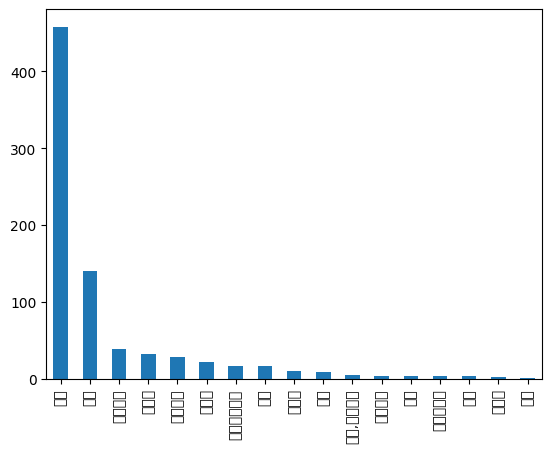

In [28]:
submit['label'].value_counts().plot(kind='bar')

In [29]:
# todo : convnext의 val값이 올라도 성능 저하 확인